# Spectroscopic factors

__Author:__ A. J. Tropiano [atropiano@anl.gov]<br/>
__Date:__ October 8, 2021

This notebook serves as a testbed for calculating spectroscopic overlaps using mean field approximations for initial and final states and applying SRG transformations to the operator. The normalization of spectroscopic overlaps give relative spectroscopic factors. The first step is to compute the overlap of $^4\rm{He}$ with $^3\rm{H}$ and compare to [VMC calculations](https://www.phy.anl.gov/theory/research/overlaps/).

_Last update:_ October 30, 2022

__To-do list:__
* Check if you need the $(-i)^l$ factor in the Hankel transformation function. The factor may cancel out in all relevant formulas (like the overlap wave function).
* Correct $\delta U^\dagger_{\beta \gamma \alpha \gamma}$ term. It does not include $\beta > 1s_{1/2}$ currently. The other two $\alpha$ and $\gamma$ are fine.
* Idea: Try calculating matrix elements $\delta U^\dagger_{\beta \gamma \alpha \gamma}$ (or more generally $\delta U^\dagger_{\alpha \beta \gamma \delta}$) outside of $\mathbf{q}$ dependence by considering all possible combinations of single-particle quantum numbers. This would rely on Monte Carlo integration and saves all matrix elements. Then directly calculate the spectroscopic overlap by looping over $\mathbf{q}$, the remaining quantum numbers ($\beta$, $\gamma \le \rm{F}$, $m_{l_\beta}$), and calculating the product of the Clebsch-Gordan coefficient, spherical harmonic, $\phi_{\beta}(q)$, and $\delta U^\dagger_{\beta \gamma \alpha \gamma}$.
* Bug test the alternative approach.

In [1]:
# Python imports
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg as la
from numpy.polynomial.legendre import leggauss
from scipy.interpolate import interp1d, RectBivariateSpline
from scipy.special import spherical_jn, sph_harm
from sympy.physics.quantum.cg import CG
import time
import vegas

In [2]:
# Imports from A.T. codes
from scripts.figures import set_rc_parameters, label_nucleus, label_sp_state
from scripts.integration import (
    gaussian_quadrature_mesh, momentum_mesh, unattach_weights_from_matrix
)
from scripts.potentials import Potential
from scripts.srg import get_transformation
from scripts.tools import find_index, replace_periods

## Set-up

In [3]:
# Run this cell to turn on customized matplotlib graphics
set_rc_parameters()

In [4]:
# Save figures in the following directory
figures_directory = '../figures/spectroscopic_factors/'

# Load s.p. wave functions from the following directory
hfbrad_directory = '../data/dft/SLy4/'

## Functions

Move some of these functions into scripts at a later date.

In [5]:
def convert_l_to_string(l):
    """
    Returns the spectroscopic notation of the orbital angular momentum value
    l (e.g., l = 2 returns 'd').

    Parameters
    ----------
    l : int
        Orbital angular momentum of the single-particle (s.p.) state.

    Returns
    -------
    output : str
        Spectroscopic notation of s.p. state orbital angular momentum.

    """

    if l == 0:
        return 's'
    elif l == 1:
        return 'p'
    elif l == 2:
        return 'd'
    elif l == 3:
        return 'f'
    elif l == 4:
        return 'g'
    elif l == 5:
        return 'h'
    elif l == 6:
        return 'i'
    else:
        raise RuntimeError(
            "Input l value is outside the range of this function."
        )

In [6]:
def convert_l_to_int(sp_state):
    """
    Returns the orbital angular momentum given the s.p. state in spectroscopic 
    notation (e.g., '1d1p5' returns 2).

    Parameters
    ----------
    sp_state : str
        Spectroscopic notation of s.p. state (e.g., '1s0p5').

    Returns
    -------
    output : int
        Orbital angular momentum of the single-particle (s.p.) state.

    """
    
    if sp_state[1] == 's':
        return 0
    elif sp_state[1] == 'p':
        return 1       
    elif sp_state[1] == 'd':
        return 2
    elif sp_state[1] == 'f':
        return 3
    elif sp_state[1] == 'g':
        return 4
    elif sp_state[1] == 'h':
        return 5
    elif sp_state[1] == 'i':
        return 6
    else:
        raise RuntimeError(
            "Input s.p. state is outside the range of this function."
        )

In [7]:
def sp_states(nucleus_name, Z, N, print_info=False):
    """
    Return all the occupied single-particle states of the given nucleus.
    
    Parameters
    ----------
    nucleus_name : str
        Name of the nucleus (e.g., 'Ca40').
    Z : int
        Proton number.
    N : int
        Neutron number.
    print_statement : bool, optional
        Option to print information for each s.p. state in nucleus.
    
    Returns
    -------
    output : dict
        Dictionary with two keys: 'proton' and 'neutron'. Each corresponds to
        a list of all the occupied s.p. states, which are strings (e.g., '1s0p5'
        means 1s with j=1/2).
    
    Notes
    -----
    Currently we're assuming the SLy4 interaction.
    
    """

    # Go to HFBRAD directory
    densities_directory = f'../data/dft/SLy4/{nucleus_name}/'
    file_name = f'hfb_{N}_{Z}.spe'
    
    # Open file and add each occupied s.p. state to list
    neutron_states = []
    proton_states = []
    
    f = open(densities_directory + file_name, 'r')
    
    for line in f:
        
        unit = line.strip().split()  # Split up row into list
        
        # Make sure you're going through the correct data
        if (len(unit) == 12) and (unit[0] in ('1', '2')):
            
            # Only do occupied states:
            if float(unit[6]) == 1:
            
                # Integer specifying neutron or proton
                nucleon_number = unit[0]
        
                # j value
                j = int(unit[1])/2
        
                # Orbital angular momentum (int)
                l = int(unit[2])
                # Orbital angular momentum (str)
                l_str = convert_l_to_string(l)
        
                # Is this correct? (# of nodes)
                n = unit[11]
            
                # Convert s.p. state to string and append to list
                state_str = f'{n}{l_str}{j:.1f}'
            
                # Add string to neutron or proton list with periods replaced
                # by 'p'
                if nucleon_number == '1': # Neutron
                    neutron_states.append(replace_periods(state_str))
                elif nucleon_number == '2': # Proton
                    proton_states.append(replace_periods(state_str))
            
                # Print information for each state?
                if print_info:
                
                    info = (f"Nuc={nucleon_number}, N={unit[4]},"
                            f" state={state_str}")
                    print(info)
                
    f.close()
    
    return {'neutron' : neutron_states, 'proton' : proton_states}

In [8]:
def get_phi_rspace(nucleus_name, Z, N, nucleon, sp_state,
                   print_normalization=False):
    """Returns the single-particle wave function in coordinate space."""
    
    if nucleon == 'proton':
        nuc_int = 1
    elif nucleon == 'neutron':
        nuc_int = 0
    
    file_name = f'{nucleon}_{sp_state}_{N}_{Z}.gfx'
    
    data = np.loadtxt(hfbrad_directory + f"{nucleus_name}/wfs/{file_name}")

    r_array = data[:, 0]  # Units fm
    dr = r_array[1] - r_array[0]  # Linear spacing between r points
    phi_array = data[:, 2]  # Units fm^-1/2
    
    # These are normalized as \int dr |u(r)|^2 = 1
    if print_normalization:
        print(f"Normalization = {np.sum(dr*phi_array**2)}.")
    
    return r_array, phi_array

In [9]:
def plot_sp_wfs_rspace(nucleus_name, Z, N, x_limits=(0.0,10.0),
                       y_limits=(0.0,0.8), save=False):
    """Plot the s.p. wave functions of a nucleus in coordinate space."""

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    # Get the data
    d = sp_states(nucleus_name, Z, N)
    
    # Plot just the proton wave functions
    for i, sp_state in enumerate(d['proton']):
        
        r_array, phi_array = get_phi_rspace(nucleus_name, Z, N, 'proton',
                                            sp_state)
        
        ax.plot(r_array, phi_array, label=label_sp_state(sp_state),
                linewidth=2.0)
        
    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$r$ [fm]", fontsize=16)
    ax.set_ylabel(r"$u(r)$ [fm" + r'$^{-1/2}$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Save?
    if save:
        file_name = f'{nucleus_name}_sp_wfs_rspace_SLy4.png'
        f.savefig(figures_directory + file_name)

In [10]:
def hankel_transformation(l, k_array, r_array, dr):
    """
    <k|r> transformation matrix for given orbital angular momentum l. If
    len(r_array) = m and len(k_array) = n, then this function returns an 
    n x m matrix.
    
    Parameters
    ----------
    l : int
        Orbital angular momentum.
    k_array : 1-D ndarray
        Momentum array [fm^-1].
    r_array : 1-D ndarray
        Coordinates array [fm].
    dr : float
        Coordinates step-size (weight) [fm].
        
    Returns
    -------
    M : 2-D ndarray
        Hankel transformation matrix [fm^3\2].
        
    Notes
    -----
    There is a "missing" factor of r in the transformation matrix since the
    radial wave functions are already multiplied by r, meaning the
    normalization is \int dr |u(r)|^2 = 1 without the r^2.

    """
    
    # r_array column vectors and k_array row vectors where both grids are
    # n x m matrices
    r_cols, k_rows = np.meshgrid(r_array, k_array)
        
    # M = (-1j)**l * np.sqrt(2/np.pi) * dr * r_cols * spherical_jn(l, k_rows * r_cols)
    M = np.sqrt(2/np.pi) * dr * r_cols * spherical_jn(l, k_rows * r_cols)

    return M

In [11]:
def get_phi_kspace(nucleus_name, Z, N, nucleon, sp_state,
                   print_normalization=False):
    """Returns the single-particle wave function in momentum space."""
    
    # Set momentum mesh
    k_array, k_weights = momentum_mesh(15.0, 3.0, 120)
    
    # Get coordinate-space s.p. wave function
    r_array, phi_r_array = get_phi_rspace(nucleus_name, Z, N, nucleon, sp_state)
    dr = r_array[2] - r_array[1]  # Assuming linear spacing in coordinates
    
    # Fourier-transform the wave function to momentum space
    l = convert_l_to_int(sp_state)
    phi_k_array = hankel_transformation(l, k_array, r_array, dr) @ phi_r_array
    
    # These are normalized as \int dk k^2 |\phi(k)|^2 = 1
    if print_normalization:
        print(f"Normalization = {np.sum(k_weights*k_array**2*phi_k_array**2)}.")

    return k_array, k_weights, phi_k_array

In [12]:
def plot_sp_wfs_kspace(nucleus_name, Z, N, x_limits=(0.0,5.0),
                       y_limits=(-0.1,4.0), save=False):
    """Plot the s.p. wave functions of a nucleus in momentum space."""

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    # Get the data
    d = sp_states(nucleus_name, Z, N)
    
    # Plot just the proton wave functions
    for i, sp_state in enumerate(d['proton']):
        
        k_array, _, phi_array = get_phi_kspace(nucleus_name, Z, N, 'proton',
                                               sp_state)
        
        ax.plot(k_array, phi_array, label=label_sp_state(sp_state),
                linewidth=2.0)
        
    # Add horizontal line at y=0
    ax.axhline(0.0, color='gray', alpha=0.4, zorder=1)
        
    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$k$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    ax.set_ylabel(r"$\phi(k)$ [fm" + r'$^{3/2}$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Save?
    if save:
        file_name = f'{nucleus_name}_sp_wfs_kspace_SLy4.png'
        f.savefig(figures_directory + file_name)

## Single-particle wave functions in coordinate space

In [13]:
nucleus_name, Z, N = 'He4', 2, 2

In [14]:
phi_r_array = get_phi_rspace(nucleus_name, Z, N, 'proton', '1s0p5',
                             print_normalization=True)

Normalization = 1.0000000007365384.


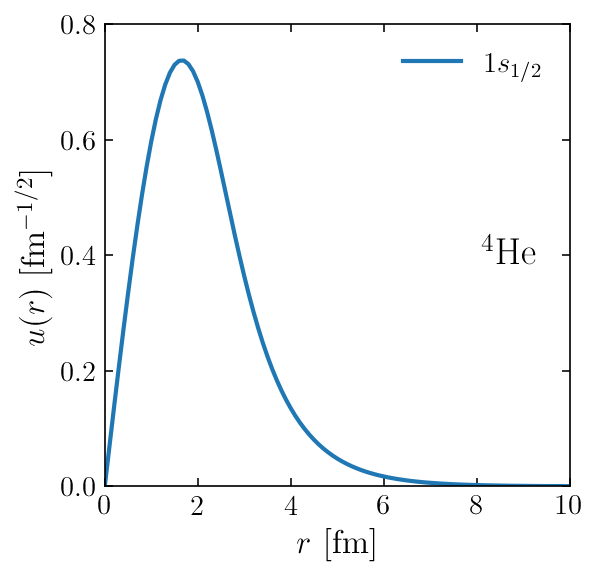

In [15]:
plot_sp_wfs_rspace(nucleus_name, Z, N, save=True)

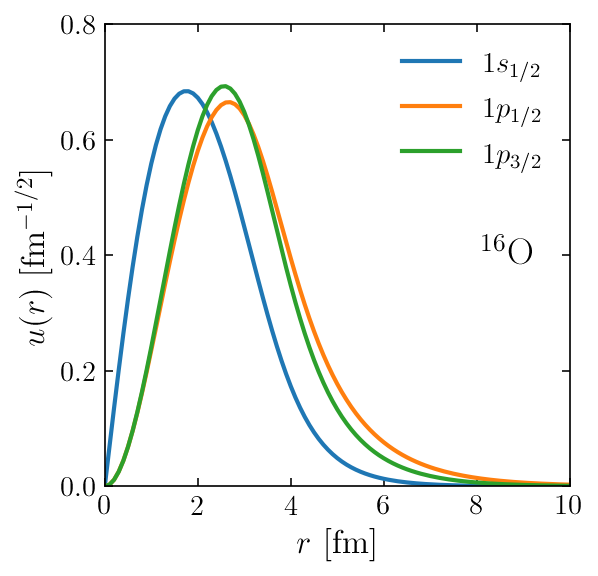

In [16]:
plot_sp_wfs_rspace('O16', 8, 8, save=True)

## Single-particle wave functions in momentum space

In [17]:
k_array, k_weights, phi_k_array = get_phi_kspace(
    nucleus_name, Z, N, 'proton', '1s0p5', print_normalization=True
)

Normalization = 1.0000000007365952.


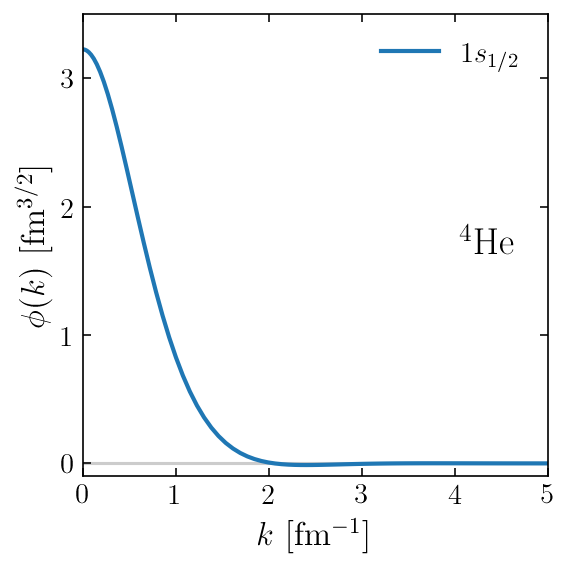

In [18]:
plot_sp_wfs_kspace(nucleus_name, Z, N, y_limits=(-0.1,3.5), save=True)

## Spectroscopic overlaps

In [19]:
def get_vmc_data(print_normalization=False):
    """Loads the VMC spectroscopic overlap."""
    
    file_name = "he4_overlap.txt"
    
    f = open(file_name, 'r')
    data_list = []
    
    for line in f:
        
        unit = line.strip().split()
        if unit[0] == "#":
            pass
        else:
            data_list.append([
                float(unit[0]), float(unit[1]),
                float(unit[2].strip('(').strip(')'))
            ])
            
    # Convert to NumPy array
    data = np.array(data_list)
    
    if print_normalization:
        q_array = data[:,0]
        dq = q_array[2]-q_array[1]
        overlap_array = data[:,1]
        print(1/(2*np.pi)**3*np.sum(dq*q_array**2*overlap_array**2))
    
    return data

In [20]:
data = get_vmc_data(print_normalization=True)

1.6221510359897304


__First approach:__ The following calculation is based on equation (23) in the Overleaf notes.

In [21]:
def interpolate_phi_kspace(nucleon):
    """Interpolate s.p. wave functions \phi(k)."""
    
    k_array, _, phi_array = get_phi_kspace('He4', 2, 2, nucleon, '1s0p5')

    # Interpolate s.p. wave functions
    phi_func = interp1d(k_array, phi_array, kind='linear', bounds_error=False,
                        fill_value='extrapolate')

    return phi_func

In [22]:
# Note, this needs to be updated to do coupled-channels (not just 3S1-3S1)
def interpolate_deltaU_dagger(kvnn, channel, lamb, kmax, kmid, ntot, generator):
    """Interpolate \delta U^\dagger(k',k)."""

    # Set potential
    potential = Potential(kvnn, channel, kmax, kmid, ntot)
    
    # Get momentum mesh
    k_array, k_weights = potential.load_mesh()
    
    # Initial and evolved Hamiltonians
    H_initial = potential.load_hamiltonian()
    if generator == 'Block-diag':
        H_evolved = potential.load_hamiltonian('srg', generator, 1.0,
                                               lambda_bd=lamb)
    else:
        H_evolved = potential.load_hamiltonian('srg', generator, lamb)
    
    # Get SRG transformation from Hamiltonians
    U_matrix_weights = get_transformation(H_initial, H_evolved)[:ntot,:ntot]

    # Calculate \delta U^\dagger = (U - I)^\dagger
    I_matrix_weights = np.eye(ntot, ntot)
    delUdag_matrix_weights = (U_matrix_weights - I_matrix_weights).T
    delUdag_matrix = unattach_weights_from_matrix(k_array, k_weights,
                                                  delUdag_matrix_weights)
    
    # Interpolate \delta U^\dagger(k,k')
    delUdag_func = RectBivariateSpline(k_array, k_array, delUdag_matrix, kx=1,
                                       ky=1)

    return delUdag_func

In [23]:
def compute_deltaU_dagger_term(kvnn, lamb, kmax=15.0, kmid=3.0, ntot=120,
                               generator='Wegner'):
    """Compute the \delta U^\dagger term in the spectroscopic overlap."""
    
    # Initialize momentum and angle meshes
    k_array, k_weights = momentum_mesh(10.0, 2.0, 120)  # Relative momenta
    K_array, K_weights = gaussian_quadrature_mesh(2.0, 40)  # CoM momenta
    x_array, x_weights = leggauss(7)  # Angles between K and k' (or K and k)
    
    # Get meshgrids for (k', k, K, x)
    kp_grid, k_grid, K_grid, x_grid = np.meshgrid(k_array, k_array, K_array,
                                                  x_array, indexing='ij')
    _, _, _, dx_grid = np.meshgrid(k_weights, k_weights, K_weights, x_weights,
                                   indexing='ij')
    
    # Get s.p. wave functions
    phi_p_func = interpolate_phi_kspace('proton')
    phi_n_func = interpolate_phi_kspace('neutron')
    
    # Evaluate product of s.p. wave functions and attach weights dx (or dy)
    # These are 4-D arrays (k', k, K, x)
    pp_kp_K_y_grid = (
        phi_p_func(
            np.sqrt(K_grid**2/4 + kp_grid**2 + kp_grid*K_grid*x_grid)
        )
        * phi_p_func(
            np.sqrt(K_grid**2/4 + kp_grid**2 - kp_grid*K_grid*x_grid)
        )
    ) * dx_grid
    pn_kp_K_y_grid = (
        phi_p_func(
            np.sqrt(K_grid**2/4 + kp_grid**2 + kp_grid*K_grid*x_grid)
        )
        * phi_n_func(
            np.sqrt(K_grid**2/4 + kp_grid**2 - kp_grid*K_grid*x_grid)
        )
    ) * dx_grid
    pp_k_K_x_grid = (
        phi_p_func(
            np.sqrt(K_grid**2/4 + k_grid**2 + k_grid*K_grid*x_grid)
        )
        * phi_p_func(
            np.sqrt(K_grid**2/4 + k_grid**2 - k_grid*K_grid*x_grid)
        )
    ) * dx_grid
    pn_k_K_x_grid = (
        phi_p_func(
            np.sqrt(K_grid**2/4 + k_grid**2 + k_grid*K_grid*x_grid)
        )
        * phi_n_func(
            np.sqrt(K_grid**2/4 + k_grid**2 - k_grid*K_grid*x_grid)
        )
    ) * dx_grid
    
    # Perform angle-averaging integrals (x and y) -> 3-D arrays (k', k, K)
    pp_kp_K_grid = 0.5 * np.sum(pp_kp_K_y_grid, axis=-1)
    pn_kp_K_grid = 0.5 * np.sum(pn_kp_K_y_grid, axis=-1)
    pp_k_K_grid = 0.5 * np.sum(pp_k_K_x_grid, axis=-1)
    pn_k_K_grid = 0.5 * np.sum(pn_k_K_x_grid, axis=-1)
    
    # Evaluate product of s.p. wave functions and attach dK K^2
    _, _, dK_grid = np.meshgrid(k_weights, k_weights, K_array**2 * K_weights,
                                indexing='ij')
    pppp_kp_k_K_grid = pp_kp_K_grid * pp_k_K_grid * dK_grid
    pnpn_kp_k_K_grid = pn_kp_K_grid * pn_k_K_grid * dK_grid
    
    # Integrate over K -> 2-D arrays (k', k)
    pppp_kp_k_grid = np.sum(pppp_kp_k_K_grid, axis=-1)
    pnpn_kp_k_grid = np.sum(pnpn_kp_k_K_grid, axis=-1)
    
    # Get \delta U^\dagger(k',k) and evaluate integrand with dk' k'^2 dk k^2
    delUdag_1S0_func = interpolate_deltaU_dagger(kvnn, '1S0', lamb, kmax,
                                                 kmid, ntot, generator)
    delUdag_1S0_grid = delUdag_1S0_func(k_array, k_array)
    delUdag_3S1_func = interpolate_deltaU_dagger(kvnn, '3S1', lamb, kmax,
                                                 kmid, ntot, generator)
    delUdag_3S1_grid = delUdag_3S1_func(k_array, k_array)
    
    dkp_grid, dk_grid = np.meshgrid(k_array**2 * k_weights,
                                    k_array**2 * k_weights, indexing='ij')
    
    integrand = (
        (pppp_kp_k_grid * delUdag_1S0_grid + 0.5 * pnpn_kp_k_grid 
         * (delUdag_1S0_grid+3*delUdag_3S1_grid))
    ) * dkp_grid * dk_grid
    
    # Integrate over k and kp -> reduced to a number at this point
    return np.sum(np.sum(integrand, axis=-1), axis=-1)

In [24]:
compute_deltaU_dagger_term(6, 1.35)

-0.06668886494761395

In [25]:
compute_deltaU_dagger_term(6, 2.0)

-0.03213484766019262

In [26]:
def spectroscopic_overlap(kvnn, lamb, kmax=15.0, kmid=3.0, ntot=120,
                          generator='Wegner', sanity_check=False):
    """Compute the spectroscopic overlap."""
    
    # Give an option to set \delta U^\dagger term to zero for sanity check
    if sanity_check:
        delUdag_term = 0.0
    else:
        delUdag_term = compute_deltaU_dagger_term(kvnn, lamb, kmax, kmid, ntot,
                                                  generator)
        
    # Get s.p. wave function for 1s_1/2 proton in He4
    q_array, q_weights, phi_array = get_phi_kspace('He4', 2, 2, 'proton',
                                                   '1s0p5')
    
    # Y_00(\qhat) is simple
    Y_00 = 1/np.sqrt(4*np.pi)
    
    # Sum I and \delta U^\dagger terms and tack on \phi(q) Y_00(\qhat)
    return q_array, q_weights, Y_00 * phi_array * (1 + delUdag_term)

In [27]:
def spectroscopic_factor(kvnn, lamb, kmax=15.0, kmid=3.0, ntot=120,
                         generator='Wegner', sanity_check=False):
    """Compute the normalization of the spectroscopic overlap."""
    
    # Get the spectroscopic overlap and momenta (with weights)
    q_array, q_weights, overlap_array = spectroscopic_overlap(
        kvnn, lamb, kmax, kmid, ntot, generator, sanity_check
    )
    
    return 4 * np.pi * np.sum(q_weights * q_array**2 * abs(overlap_array)**2)

In [28]:
2*spectroscopic_factor(6, 1.35, sanity_check=True)

2.0000000014731905

In [29]:
2*spectroscopic_factor(6, 1.35)

1.742139350908798

In [30]:
2*spectroscopic_factor(6, 2.0)

1.8735259076075474

In [31]:
def plot_spectroscopic_overlap(
        q_array, q_weights, overlap_array, x_limits=(0.0,10.0),
        y_limits=(1e-5,1e2), y_scale='log', show_vmc=False, save=False):
    """Plot the spectrosopic overlap as a function of momentum q."""

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))

    factor = np.sqrt(4 * np.pi * 2 * (2*np.pi)**3)
    
    # Plot just the proton overlap
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
    
    # Compare to VMC calculation?
    if show_vmc:
        data = get_vmc_data()
        q_array_vmc = data[:,0]
        overlap_array_vmc = data[:,1]
        ax.plot(q_array_vmc, abs(overlap_array_vmc), label='VMC', linewidth=2.0)
    
    # Take absolute value
    ax.plot(q_array, abs(overlap_array)*factor, label=label_sp_state('1s0p5'),
            linewidth=2.0)
    
    # TESTING
    print(1/(2*np.pi)**3*np.sum(q_weights*q_array**2*overlap_array**2*factor**2))

    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    ax.set_ylabel(r"$A(q)$ [fm" + r'$^{3/2}$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Save?
    if save:
        file_name = f'{nucleus_name}_overlap_{kvnn}_{lamb}_SLy4.png'
        f.savefig(figures_directory + file_name)

1.742139350908798


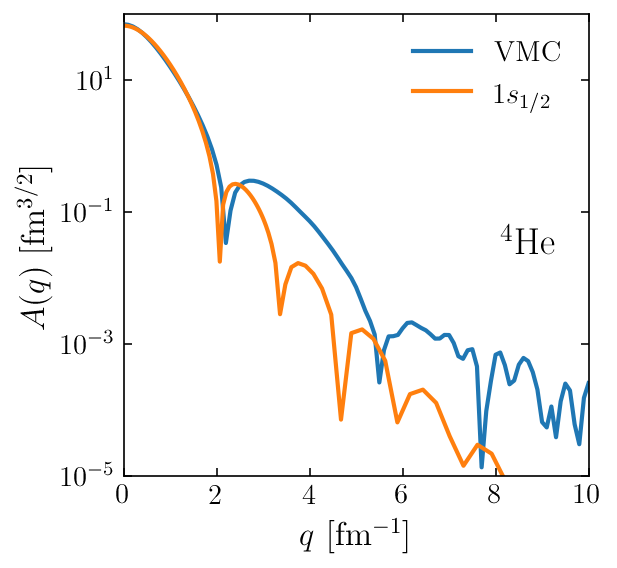

In [32]:
q_array, q_weights, overlap_array = spectroscopic_overlap(6, 1.35)
plot_spectroscopic_overlap(q_array, q_weights, overlap_array, show_vmc=True)

__Second approach:__ Different calculation to get two-body operator using plane wave basis first, then switching to s.p. basis.

In [33]:
def spectroscopic_overlap_v2(kvnn, lamb, kmax=15.0, kmid=3.0, ntot=120,
                             generator='Wegner', sanity_check=False):
    """Compute the spectroscopic overlap."""
    
    # Initialize momentum and angle meshes
    q_array, q_weights = momentum_mesh(10.0, 2.0, 120)  # s.p. momenta
    k_array, k_weights = momentum_mesh(10.0, 2.0, 120)  # Relative momenta
    K_array, K_weights = gaussian_quadrature_mesh(2.0, 40)  # CoM momenta
    x_array, x_weights = leggauss(7)  # Angles between q and K (or K and k)
    
    # Get meshgrids for q, k, and K (weights too)
    q_grid, k_grid, K_grid = np.meshgrid(q_array, k_array, K_array,
                                         indexing='ij')
    _, dk_grid, dK_grid = np.meshgrid(
        q_array, k_array**2 * k_weights, K_array**2 * K_weights, indexing='ij'
    )
    
    # Get s.p. wave functions
    phi_p_func = interpolate_phi_kspace('proton')
    phi_n_func = interpolate_phi_kspace('neutron')
    
    # Get \delta U^\dagger function and evaluate at (|\qvec-\Kvec/2|, k)
    delUdag_1S0_func = interpolate_deltaU_dagger(kvnn, '1S0', lamb, kmax,
                                                 kmid, ntot, generator)
    delUdag_3S1_func = interpolate_deltaU_dagger(
        kvnn, '3S1', lamb, kmax, kmid, ntot, generator
    )
    
    # Initialize integrand
    integrand_k_K = np.zeros_like(q_grid)
    
    # Do angle-averaging integrals
    for x, dx in zip(x_array, x_weights):
        
        K_minus_q = np.sqrt(K_grid**2 + q_grid**2 - 2*K_grid*q_grid*x)
        q_minus_K_over_two = np.sqrt(q_grid**2 + K_grid**2/4 + K_grid*q_grid*x)
        
        phi_p_K_minus_q = phi_p_func(K_minus_q)
        phi_n_K_minus_q = phi_n_func(K_minus_q)
        
        delUdag_1S0_grid = delUdag_1S0_func.ev(q_minus_K_over_two, k_grid)
        delUdag_3S1_grid = delUdag_3S1_func.ev(q_minus_K_over_two, k_grid)
        
        for y, dy in zip(x_array, x_weights):
            
            K_over_two_plus_k = np.sqrt(
                K_grid**2/4 + k_grid**2 + K_grid*k_grid*y
            )
            K_over_two_minus_k = np.sqrt(
                K_grid**2/4 + k_grid**2 - K_grid*k_grid*y
            )
            
            phi_p_K_over_two_plus_k = phi_p_func(K_over_two_plus_k)
            phi_p_K_over_two_minus_k = phi_p_func(K_over_two_minus_k)
            phi_n_K_over_two_minus_k = phi_n_func(K_over_two_minus_k)
            
            integrand_k_K += dx/2 * dy/2 * phi_p_K_over_two_plus_k * (
                phi_p_K_minus_q * phi_p_K_over_two_minus_k * delUdag_1S0_grid
                + 0.5 * phi_n_K_minus_q * phi_n_K_over_two_minus_k
                * (delUdag_1S0_grid + 3*delUdag_3S1_grid)
            )
            
    # Integrate over K and k
    deltaU_dag_term = np.sum(
        np.sum(dk_grid * dK_grid * integrand_k_K, axis=-1), axis=-1
    )

    # Give an option to set \delta U^\dagger term to zero for sanity check
    if sanity_check:
        deltaU_dag_term = np.zeros_like(q_array)
    
    # Integrate over k and add to \phi_p(q) for full spectroscopic overlap
    return q_array, q_weights, 1/np.sqrt(4*np.pi) * (
        phi_p_func(q_array) + 2*deltaU_dag_term
    )

In [34]:
def spectroscopic_factor_v2(kvnn, lamb, kmax=15.0, kmid=3.0, ntot=120,
                            generator='Wegner', sanity_check=False):
    """Compute the normalization of the spectroscopic overlap."""
    
    # Get the spectroscopic overlap and momenta (with weights)
    q_array, q_weights, overlap_array = spectroscopic_overlap_v2(
        kvnn, lamb, kmax, kmid, ntot, generator, sanity_check
    )
    
    return 4 * np.pi * np.sum(q_weights * q_array**2 * abs(overlap_array)**2)

In [35]:
spectroscopic_factor_v2(6, 1.35, sanity_check=True)

1.0015663675253905

In [36]:
spectroscopic_factor_v2(6, 1.35)

1.1387345187432543

In [37]:
spectroscopic_factor_v2(6, 2.0)

0.9659994673596157

2.2774690374865085


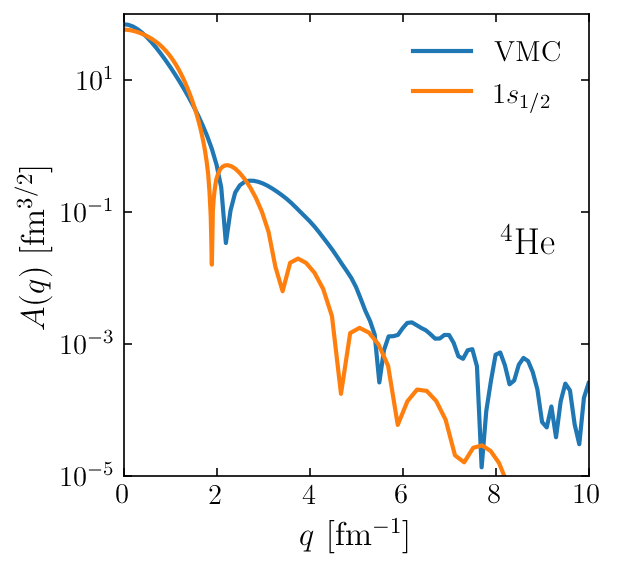

In [38]:
# Plot spectroscopic overlap
q_array, q_weights, overlap_array = spectroscopic_overlap_v2(6, 1.35)
plot_spectroscopic_overlap(q_array, q_weights, overlap_array, show_vmc=True)

__Third approach:__ This is the same as the first approach but using Monte Carlo integration for the integrals over momenta.

_Observations:_
* The spherical harmonics can be complex but it appears `vegas` only takes real-valued functions.
* Looping over $\theta_q$ and $\phi_q$ slows down the calculation quite a bit. We can simplify for knocking out to $s$-wave states; however, this is not the most general way.
* I think the CG function is slowing down the calculation quite a bit (see `test_vegas.ipynb`). How about building a dictionary for all combinations of $j_1$, $m_{j_1}$, $j_2$, $m_{j_2}$, $j_3$, and $m_{j_3}$? E.g., call `self.cg_table[(j_1, m_1, j_2, m_2, j_3, m_3)]`, which corresponds to `float(CG(j_1, m_1, j_2, m_2, j_3, m_3).doit())`.

In [46]:
class SpectroscopicOverlap:
    
    # relies on a function outside the class...
    def __init__(self, channels, kvnn, lamb, kmax=15.0, kmid=3.0, ntot=120,
                 generator='Wegner'):
        
        self.channels = channels
        
        # Set arrays for quantum numbers
        self.spins = np.array([1/2, -1/2])
        self.isospins = self.spins
        self.total_spins = np.array([1, 0, -1])
        self.betas = ['1s0p5']  # This should go beyond F
        self.gammas = ['1s0p5']
        
        # Set interpolating functions for s.p. wave functions \phi
        self.phi_p_func = interpolate_phi_kspace('proton')
        self.phi_n_func = interpolate_phi_kspace('neutron')
    
        # Set interpolating functions for \delta U^\dagger
        self.deltaU_dag_func_1S0 = interpolate_deltaU_dagger(
            kvnn, '1S0', lamb, kmax, kmid, ntot, generator
        )
        self.deltaU_dag_func_3S1_3S1 = interpolate_deltaU_dagger(
            kvnn, '3S1', lamb, kmax, kmid, ntot, generator
        )
        # self.deltaU_dag_func_3S1_3D1 = None
        
        # Calculate all possible Clebsch-Gordan coefficients
        self.cg_table = self.get_cg_table()
    
    def get_channel_quantum_numbers(self, channel):
    
        S = int((int(channel[0])-1)/2)
        J = int(channel[2])
    
        if channel[1] == 'S':
            Lp = 0
        elif channel[1] == 'P':
            Lp = 1
        else:
            Lp = 2
    
        if len(channel) > 3:
        
            if channel[5] == 'S':
                L = 0
            elif channel[5] == 'P':
                L = 1
            else:
                L = 2
            
        else:
        
            L = Lp
            
        return S, Lp, L, J
    
    def get_total_isospin(self, S, L):
    
        if (1-(-1)**(L+S)) == 0:
            T = 1
        else:
            T = 0
        
        return T
    
    def get_sp_quantum_numbers(self, sp_state):
    
        n = int(sp_state[0])
    
        if sp_state[1] == 's':
            l = 0
        elif sp_state[1] == 'p':
            l = 1
        elif sp_state[1] == 'd':
            l = 2
        else:
            l = 3
        
        j_str = sp_state[2:]
        if j_str == '0p5':
            j = 1/2
        elif j_str == '1p5':
            j = 3/2
        else:
            j = 5/2
        
        return n, l, j
    
    def get_cg_table(self):
        
        cg_table = {}
        
        # Get largest possible j value
        j_max = 3
        j_array = np.arange(0, j_max+1/2, 1/2)

        for j_1 in j_array:
            for m_1 in np.arange(-j_1, j_1+1, 1):
                for j_2 in j_array:
                    for m_2 in np.arange(-j_2, j_2+1, 1):
                        for j_3 in j_array:
                            for m_3 in np.arange(-j_3, j_3+1, 1):
                                cg_table[(j_1,m_1,j_2,m_2,j_3,m_3)] = float(
                                    CG(j_1,m_1,j_2,m_2,j_3,m_3).doit()
                                )
                                
        return cg_table
        
    def delta_U_dagger_integrand(self, x):

        # \tau_\beta is fixed to \tau_\alpha
        tau_beta = self.tau_alpha
        
        k1, theta1, phi1 = x[:3]
        k1_vector = np.array([k1*np.sin(theta1)*np.cos(phi1),
                              k1*np.sin(theta1)*np.sin(phi1),
                              k1*np.cos(theta1)])
        
        k2, theta2, phi2 = x[3:6]
        k2_vector = np.array([k2*np.sin(theta2)*np.cos(phi2),
                              k2*np.sin(theta2)*np.sin(phi2),
                              k2*np.cos(theta2)])
        
        k3, theta3, phi3 = x[6:]
        k3_vector = np.array([k3*np.sin(theta3)*np.cos(phi3),
                              k3*np.sin(theta3)*np.sin(phi3),
                              k3*np.cos(theta3)])
        
        # Calculate the Jacobian determinant
        jacobian = (k1**2 * np.sin(theta1) * k2**2 * np.sin(theta2) * k3**2 
                    * np.sin(theta3))
        
        # Compute k_4 vector and each of its components
        k4_vector = k1_vector + k2_vector - k3_vector
        k4 = la.norm(k4_vector)
        theta4 = np.arccos(k4_vector[2]/k4)
        phi4 = np.arctan2(k4_vector[1], k4_vector[0])
        
        # Compute k' vector and each of its components
        kp_vector = (k1_vector-k2_vector)/2
        kp = la.norm(kp_vector)
        thetap = np.arccos(kp_vector[2]/kp)
        phip = np.arctan2(kp_vector[1], kp_vector[0])
        
        # Compute k vector and each of its components
        k_vector = (k3_vector-k4_vector)/2
        k = la.norm(k_vector)
        theta = np.arccos(k_vector[2]/k)
        phi = np.arctan2(k_vector[1], k_vector[0])

        # Compute \phi_\alpha(k3)
        if self.tau_alpha == 1/2:
            phi_alpha = self.phi_p_func(k3)
        elif self.tau_alpha == -1/2:
            phi_alpha = self.phi_n_func(k3)
            
        integrand = 0
        # integrand = 0+0j

        # Loop over channels
        for channel in self.channels:
    
            # Determine L', L, S, J, T
            S, Lp, L, J = self.get_channel_quantum_numbers(channel)
            T = self.get_total_isospin(S, Lp)
    
            total_angular_momentum_projections = np.arange(-J, J+1, 1)
            total_isospin_projections = np.intersect1d(
                np.arange(-T, T+1, 1), self.tau_alpha - self.isospins
            )
    
            # Compute 1-(-1)^(L'+S+T) and 1-(-1)^(L+S+T) factors
            factor = (1-(-1)**(Lp+S+T)) * (1-(-1)**(L+S+T))
    
            # Compute \delta U^\dagger(k', k) (make a function for this)
            if channel[:3] == '1S0':
                delta_U_dagger = self.deltaU_dag_func_1S0.ev(kp, k)
            elif channel[:3] == '3S1':
                if channel[-3:] == '3S1':
                    delta_U_dagger = self.deltaU_dag_func_3S1_3S1.ev(kp, k)
                else:
                    delta_U_dagger = self.deltaU_dag_func_3S1_3D1.ev(kp, k)
            elif channel[:3] == '3D1':
                if channel[-3:] == '3S1':
                    delta_U_dagger = self.deltaU_dag_func_3D1_3S1.ev(kp, k)
                else:
                    delta_U_dagger = self.deltaU_dag_func_3D1_3D1.ev(kp, k)
    
            # Loop over M_T
            for M_T in total_isospin_projections:
    
                # Determine \tau_\gamma (\tau_\alpha already known)
                tau_gamma = M_T - tau_beta

                # Compute < \tau_\beta \tau_\gamma | T M_T >
#                 isospin_cg_beta_gamma = float(
#                     CG(0.5, tau_beta, 0.5, tau_gamma, T, M_T).doit()
#                 )
                isospin_cg_beta_gamma = self.cg_table[(
                    0.5, tau_beta, 0.5, tau_gamma, T, M_T
                )]
        
                # Compute < T M_T | \tau_\alpha \tau_\gamma >
#                 isospin_cg_alpha_gamma = float(
#                     CG(0.5, self.tau_alpha, 0.5, tau_gamma, T, M_T).doit()
#                 )
                isospin_cg_alpha_gamma = self.cg_table[(
                    0.5, self.tau_alpha, 0.5, tau_gamma, T, M_T
                )]
        
                for beta in self.betas:

                    # Determine n_\beta, l_\beta, j_\beta
                    n_beta, l_beta, j_beta = self.get_sp_quantum_numbers(beta)
            
                    # Compute \phi_\beta(k1), \phi_\beta(q)
                    if tau_beta == 1/2:
                        phi_beta_conj = self.phi_p_func(k1)
                        phi_beta = self.phi_p_func(self.q)
                    elif tau_beta == -1/2:
                        phi_beta_conj = self.phi_n_func(k1)
                        phi_beta = self.phi_n_func(self.q)
            
                    # Loop over \gamma
                    for gamma in self.gammas:
            
                        # Determine n_\gamma, l_\gamma, j_\gamma
                        n_gamma, l_gamma, j_gamma = self.get_sp_quantum_numbers(
                            gamma
                        )
                
                        # Compute \phi_\gamma(k2), \phi_\gamma(k4)
                        if tau_gamma == 1/2:
                            phi_gamma_conj = self.phi_p_func(k2)
                            phi_gamma = self.phi_p_func(k4)
                        elif tau_gamma == -1/2:
                            phi_gamma_conj = self.phi_n_func(k2)
                            phi_gamma = self.phi_n_func(k4)
                
                        # Loop over m_l_\alpha
                        m_l_alphas = np.intersect1d(
                            np.arange(-self.l_alpha, self.l_alpha+1, 1),
                            self.m_j_alpha - self.spins
                        )
                        for m_l_alpha in m_l_alphas:

                            # Compute Y_{l_\alpha m_l_\alpha}(k3)
                            Y_alpha = sph_harm(m_l_alpha, self.l_alpha, phi3,
                                               theta3)
                    
                            # Determine \sigma_\alpha
                            sigma_alpha = self.m_j_alpha - m_l_alpha
                    
                            # Compute < l_\alpha m_l_\alpha 1/2 \sigma_\alpha | j_\alpha m_j_\alpha >
#                             alpha_cg = float(
#                                 CG(self.l_alpha, m_l_alpha, 1/2, sigma_alpha,
#                                    self.j_alpha, self.m_j_alpha).doit()
#                             )
                            alpha_cg = self.cg_table[(
                                self.l_alpha, m_l_alpha, 1/2, sigma_alpha,
                                self.j_alpha, self.m_j_alpha
                            )]
                    
                            # Loop over m_j_\beta
                            for m_j_beta in np.arange(-j_beta, j_beta+1, 1):
                
                                # Loop over m_l_\beta'
                                m_l_betas = np.intersect1d(
                                    np.arange(-l_beta, l_beta+1, 1),
                                    m_j_beta - self.spins
                                )
                                for m_l_betap in m_l_betas:
                    
                                    # Compute Y_{l_\beta m_l_\beta'}(k1)
                                    Y_betap = sph_harm(m_l_betap, l_beta, phi1,
                                                       theta1)
                        
                                    # Determine \sigma_\beta'
                                    sigma_betap = m_j_beta - m_l_betap
                            
                                    # Compute < j_\beta m_j_\beta | l_\beta m_l_\beta' 1/2 \sigma_\beta' >
#                                     betap_cg = float(
#                                         CG(l_beta, m_l_betap, 1/2, sigma_betap,
#                                            j_beta, m_j_beta).doit()
#                                     )
                                    betap_cg = self.cg_table[(
                                        l_beta, m_l_betap, 1/2, sigma_betap,
                                        j_beta, m_j_beta
                                    )]
                
                                    # Loop over m_l_\beta
                                    for m_l_beta in m_l_betas:
                        
                                        # Compute Y_{l_\beta m_l_\beta}(q)
                                        Y_beta = sph_harm(
                                            m_l_beta, l_beta, self.phi_q,
                                            self.theta_q)
                            
                                        # Determine \sigma_\beta
                                        sigma_beta = m_j_beta - m_l_beta
                                
                                        # Compute < l_\beta m_l_\beta 1/2 \sigma_\beta | j_\beta m_j_\beta >
#                                         beta_cg = float(
#                                             CG(
#                                                 l_beta, m_l_beta, 1/2,
#                                                 sigma_beta, j_beta,m_j_beta
#                                             ).doit()
#                                         )
                                        beta_cg = self.cg_table[(
                                            l_beta, m_l_beta, 1/2, sigma_beta,
                                            j_beta, m_j_beta
                                        )]
                            
                                        # Loop over m_j_\gamma
                                        for m_j_gamma in np.arange(-j_gamma, j_gamma+1, 1):
                            
                                            # Loop over m_l_\gamma'
                                            m_l_gammas = np.intersect1d(
                                                np.arange(-l_gamma,l_gamma+1,1),
                                                m_j_gamma - self.spins
                                            )
                                            for m_l_gammap in m_l_gammas:
                                
                                                # Compute Y_{l_\gamma m_l_\gamma'}(k2)
                                                Y_gammap = sph_harm(
                                                    m_l_gammap, l_gamma, phi2,
                                                    theta2
                                                )
                                    
                                                # Determine \sigma_\gamma'
                                                sigma_gammap = m_j_gamma - m_l_gammap
                                        
                                                # Compute < j_\gamma m_j_\gamma | l_\gamma m_l_\gamma' 1/2 \sigma_\gamma' >
#                                                 gammap_cg = float(
#                                                     CG(l_gamma, m_l_gammap, 1/2,
#                                                        sigma_gammap, j_gamma,
#                                                        m_j_gamma).doit()
#                                                 )
                                                gammap_cg = self.cg_table[(
                                                    l_gamma, m_l_gammap, 1/2,
                                                    sigma_gammap, j_gamma,
                                                    m_j_gamma
                                                )]
                                        
                                                # Loop over m_l_\gamma
                                                for m_l_gamma in m_l_gammas:

                                                    # Compute Y_{l_\gamma m_l_\gamma}(k4)
                                                    Y_gamma = sph_harm(
                                                        m_l_gamma, l_gamma,
                                                        phi4, theta4
                                                    )
                                        
                                                    # Determine \sigma_\gamma
                                                    sigma_gamma = m_j_gamma - m_l_gamma
                                        
                                                    # Compute < l_\gamma m_l_\gamma 1/2 \sigma_\gamma | j_\gamma m_j_\gamma >
#                                                     gamma_cg = float(
#                                                         CG(l_gamma, m_l_gamma, 1/2, sigma_gamma, j_gamma, m_j_gamma).doit()
#                                                     )
                                                    gamma_cg = self.cg_table[(
                                                        l_gamma, m_l_gamma, 1/2,
                                                        sigma_gamma, j_gamma,
                                                        m_j_gamma
                                                    )]
                                        
                                                    # Loop over M_J and M_L
                                                    for M_J in total_angular_momentum_projections:
                                                        for M_L in np.arange(-L, L+1, 1):
                                            
                                                            # Determine M_L'
                                                            M_Lp = M_L
                                                
                                                            # Compute Y_{L' M_L'}(k')
                                                            Y_Lp = sph_harm(
                                                                M_Lp, Lp, phip,
                                                                thetap
                                                            )
                                                            # Compute Y_{L M_L}(k)
                                                            Y_L = sph_harm(
                                                                M_L, L, phi,
                                                                theta
                                                            )
                                                
                                                            # Determine M_S
                                                            M_S = M_J - M_L
                                                
                                                            # Compute < \sigma_\beta' \sigma_\gamma' | S M_S >
#                                                             spin_cg_betap_gammap = float(
#                                                                 CG(1/2, sigma_betap, 1/2, sigma_gammap, S, M_S).doit()
#                                                             )
                                                            spin_cg_betap_gammap = self.cg_table[(
                                                                1/2, sigma_betap, 1/2, sigma_gammap, S, M_S
                                                            )]
                                        
                                                            # Compute < S M_S | \sigma_\alpha \sigma_\gamma >
#                                                             spin_cg_alpha_gamma = float(
#                                                                 CG(1/2, sigma_alpha, 1/2, sigma_gamma, S, M_S).doit()
#                                                             )
                                                            spin_cg_alpha_gamma = self.cg_table[(
                                                                1/2, sigma_alpha, 1/2, sigma_gamma, S, M_S
                                                            )]
                                                            # Note, these last two CG's can be zero!
                                                
                                                            # Compute < L' M_L' S M_S | J M_J >
#                                                             Lp_S_J_cg = float(
#                                                                 CG(Lp, M_Lp, S, M_S, J, M_J).doit()
#                                                             )
                                                            Lp_S_J_cg = self.cg_table[(
                                                                Lp, M_Lp, S, M_S, J, M_J
                                                            )]
                                
                                                            # Calculate < J M_J | L M_L S M_S >
#                                                             L_S_J_cg = float(
#                                                                 CG(L, M_L, S, M_S, J, M_J).doit()
#                                                             )
                                                            L_S_J_cg = self.cg_table[(
                                                                L, M_L, S, M_S, J, M_J
                                                            )]

                                                            # Add to integrand
                                                            integrand += (
                                                                jacobian
                                                                * betap_cg
                                                                * gammap_cg
                                                                * alpha_cg
                                                                * beta_cg
                                                                * gamma_cg
                                                                * spin_cg_betap_gammap
                                                                * spin_cg_alpha_gamma
                                                                * isospin_cg_beta_gamma
                                                                * isospin_cg_alpha_gamma
                                                                * Lp_S_J_cg
                                                                * L_S_J_cg
                                                                * factor
                                                                * phi_beta_conj
                                                                * phi_gamma_conj
                                                                * phi_alpha
                                                                * phi_beta
                                                                * phi_gamma
                                                                * Y_betap
                                                                * Y_gammap
                                                                * Y_alpha
                                                                * Y_gamma
                                                                * Y_beta
                                                                * Y_Lp * Y_L
                                                                * delta_U_dagger
                                                            ) / np.sqrt(2)
                              
        return integrand
    
    def compute_I_term(self, q, theta_q, phi_q):
        
        # Compute \phi_\alpha(q)
        if self.tau_alpha == 1/2:
            phi_alpha = self.phi_p_func(q)
        elif self.tau_alpha == -1/2:
            phi_alpha = self.phi_n_func(q)
        
        # Loop over m_l_\alpha
        I_term = 0
        m_l_alphas = np.intersect1d(
            np.arange(-self.l_alpha, self.l_alpha+1, 1),
            self.m_j_alpha - self.spins
        )
        for m_l_alpha in m_l_alphas:
            
            # Compute Y_{l_\alpha m_l_\alpha}(q)
            Y_alpha = sph_harm(m_l_alpha, self.l_alpha, phi_q, theta_q)
                    
            # Determine \sigma_\alpha
            sigma_alpha = self.m_j_alpha - m_l_alpha
                    
            # Compute < l_\alpha m_l_\alpha 1/2 \sigma_\alpha | j_\alpha m_j_\alpha >
            alpha_cg = float(CG(self.l_alpha, m_l_alpha, 1/2, sigma_alpha,
                                self.j_alpha, self.m_j_alpha).doit())
            
            I_term += alpha_cg * Y_alpha * phi_alpha
            
        return I_term
    
    def compute_delta_U_dagger_term(self, q, theta_q, phi_q):
        
        t0 = time.time()
        
        # Set q, theta_q, and phi_q as instance attributes
        self.q = q
        self.theta_q = theta_q
        self.phi_q = phi_q
        
        # Compute integrations over k1, k2, and k3 vectors
        k_limits = [0, 10]
        theta_limits = [0, np.pi]
        phi_limits = [0, 2*np.pi]
        integ = vegas.Integrator([k_limits, theta_limits, phi_limits,
                                  k_limits, theta_limits, phi_limits,
                                  k_limits, theta_limits, phi_limits])

        result = integ(self.delta_U_dagger_integrand, nitn=10, neval=1e4)
        # result = integ(self.delta_U_dagger_integrand, nitn=10, neval=1e5)

        t1 = time.time()
        mins = (t1-t0)/60
        
        # TESTING
        print(result.summary())
        print(result)
        print(result.mean)
        print(result.sdev)
        print(f"Done with q = {q}, theta_q = {theta_q}, phi_q = {phi_q} after"
              f" {mins:.2f} minutes.")

        delta_U_dagger_term = result.mean
        
        return delta_U_dagger_term
                                                
    def get_overlap(self, alpha, tau_alpha, q_array, sanity_check=False):
        
        # Set \alpha quantum numbers as instance attributes
        self.tau_alpha = tau_alpha
        self.n_alpha, self.l_alpha, self.j_alpha = self.get_sp_quantum_numbers(
            alpha
        )
        self.m_j_alpha = self.j_alpha
        
        # Set range of \theta_q values from 0 to \pi
#         theta_q_array, theta_q_weights = gaussian_quadrature_mesh(np.pi, 5)
        
        # Set range of \phi_q values from 0 to 2\pi
#         phi_q_array, phi_q_weights = gaussian_quadrature_mesh(2*np.pi, 7)
        
        # Get meshgrid for integration over angles
#         _, dtheta_grid, dphi_grid = np.meshgrid(
#             q_array, np.sin(theta_q_array) * theta_q_weights, phi_q_weights,
#             indexing='ij'
#         )
        
        # Compute I term and \delta U^\dagger term for each q, theta_q, and phi_q
#         I_array = np.zeros_like(dtheta_grid, dtype=complex)
#         delta_U_dagger_array = np.zeros_like(I_array, dtype=complex)
#         I_array = np.zeros_like(dtheta_grid)
#         delta_U_dagger_array = np.zeros_like(I_array)
#         for i, q in enumerate(q_array):
#             for j, theta_q in enumerate(theta_q_array):
#                 for k, phi_q in enumerate(phi_q_array):
                    
#                     # I term
#                     I_array[i,j,k] = self.compute_I_term(q, theta_q, phi_q)
                    
#                     if sanity_check:
#                         delta_U_dagger_array[i,j,k] = 0
#                     else:
#                         # \delta U^\dagger term
#                         delta_U_dagger_array[i,j,k] = (
#                             self.compute_delta_U_dagger_term(q, theta_q, phi_q)
#                         )
        # TESTING
        I_array = np.zeros_like(q_array)
        delta_U_dagger_array = np.zeros_like(q_array)
        for i, q in enumerate(q_array):
                    
            # I term
            I_array[i] = self.compute_I_term(q, 0, 0)
                    
            if sanity_check:
                delta_U_dagger_array[i] = 0
            else:
                # \delta U^\dagger term
                delta_U_dagger_array[i] = (
                    self.compute_delta_U_dagger_term(q, 0, 0)
                )

        # Integrate over angles (leaves a 1-D array)
#         overlap_squared = np.sum(
#             np.sum(
#                 abs(I_array+delta_U_dagger_array)**2 * dtheta_grid * dphi_grid,
#             axis=-1),
#         axis=-1)
        
#         return overlap_squared

        # TESTING
        return 4*np.pi*abs(I_array+delta_U_dagger_array)**2

In [47]:
def compute_spectroscopic_factor(q_array, q_weights, overlap_array):
    
    return np.sum(q_weights * q_array**2 * overlap_array)

In [48]:
alpha = '1s0p5'
tau_alpha = 1/2

# channels = (
#     '1S0', '3S1-3S1', '3S1-3D1', '3D1-3S1', '3D1-3D1', '3P0', '3P1', '1P1'
# )
channels = ('1S0', '3S1-3S1')

kvnn = 6
lamb = 1.35

# q_array, q_weights = momentum_mesh(10.0, 2.0, 120)
# TESTING
q_array, q_weights = gaussian_quadrature_mesh(10.0, 10)

In [49]:
so = SpectroscopicOverlap(channels, kvnn, lamb)

In [50]:
# overlap_array = so.get_overlap(alpha, tau_alpha, q_array, sanity_check=True)

In [51]:
# compute_spectroscopic_factor(q_array, q_weights, overlap_array)

In [52]:
overlap_array = so.get_overlap(alpha, tau_alpha, q_array)

/var/folders/4c/p53tldwd6f76zfs85vnyk3qr0000gn/T/ipykernel_8410/3317499658.py:513: ComplexWarning: Casting complex values to real discards the imaginary part
  I_array[i] = self.compute_I_term(q, 0, 0)
/var/folders/4c/p53tldwd6f76zfs85vnyk3qr0000gn/T/ipykernel_8410/3317499658.py:449: ComplexWarning: Casting complex values to real discards the imaginary part
  result = integ(self.delta_U_dagger_integrand, nitn=10, neval=1e4)


itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   -1.4(1.7)       -1.4(1.7)           0.00     1.00
  2   -1.12(29)       -1.13(29)           0.03     0.86
  3   -0.07(66)       -0.96(27)           1.10     0.33
  4   -1.04(19)       -1.01(15)           0.75     0.52
  5   -0.99(27)       -1.01(13)           0.57     0.69
  6   -1.28(11)       -1.173(83)          0.96     0.44
  7   -1.238(73)      -1.210(55)          0.85     0.53
  8   -1.227(75)      -1.216(44)          0.74     0.64
  9   -1.362(53)      -1.276(34)          1.20     0.29
 10   -1.346(51)      -1.298(28)          1.22     0.28

-1.298(28)
-1.2976255484789319
0.028368320628364318
Done with q = 0.13046735741414128, theta_q = 0, phi_q = 0 after 1.68 minutes.
itn   integral        wgt average     chi2/dof        Q
-------------------------------------------------------
  1   0.07(41)        0.07(41)            0.00     1.00
  2   -0.20(13)       -0.17(1

In [ ]:
compute_spectroscopic_factor(q_array, q_weights, overlap_array)

## Bug testing

In [ ]:
class Debug:
    
    def __init__(
            self, nucleus_name='He4', Z=2, N=2, sp_state='1s0p5', kvnn=6,
            lamb=1.35, generator='Wegner', approach='1', kmax=15.0, kmid=3.0,
            ntot=120):
        
        self.nucleus_name = nucleus_name
        self.Z = Z
        self.N = N
        self.sp_state = sp_state
        self.kvnn = kvnn
        self.lamb = lamb
        self.generator = generator
        self.approach = approach
        self.kmax = kmax
        self.kmid = kmid
        self.ntot = ntot
        
    def get_phi_kspace(
            self, nucleon, kmax=15.0, kmid=3.0, ntot=120,
            print_phi_r_array=False, print_phi_r_norm=False,
            print_phi_k_array=False, print_phi_k_norm=False):

        # Set momentum mesh
        k_array, k_weights = momentum_mesh(kmax, kmid, ntot)
    
        # Get coordinate-space s.p. wave function
        r_array, phi_r_array = get_phi_rspace(self.nucleus_name, self.Z, self.N,
                                              nucleon, self.sp_state)
        dr = r_array[2] - r_array[1]  # Assuming linear spacing in coordinates
        
        if print_phi_r_array:
            for i,j in zip(r_array, phi_r_array):
                print(i,j)
                
        if print_phi_r_norm:
            phi_r_norm = np.sum(dr*phi_r_array**2)
            print(f"r-space normalization = {phi_r_norm}.")
    
        # Fourier-transform the wave function to momentum space
        l = convert_l_to_int(self.sp_state)
        phi_k_array = (hankel_transformation(l, k_array, r_array, dr)
                       @ phi_r_array)
        
        if print_phi_k_array:
            for i,j in zip(k_array, phi_k_array):
                print(i,j)
    
        # These are normalized as \int dk k^2 |\phi(k)|^2 = 1
        if print_phi_k_norm:
            phi_k_norm = np.sum(k_weights*k_array**2*phi_k_array**2)
            print(f"k-space normalization = {phi_k_norm}.")
            
        return k_array, k_weights, phi_k_array
    
    def plot_phi_kspace(self, k_array, phi_k_array, x_limits=(0.0,5.0),
                        y_limits=(-0.1,4.0)):
    
        # Initialize figure
        plt.close('all')
        f, ax = plt.subplots(figsize=(4, 4))
    
        ax.plot(k_array, phi_k_array, label=label_sp_state(self.sp_state),
                linewidth=2.0)
        
        # Add horizontal line at y=0
        ax.axhline(0.0, color='gray', alpha=0.4, zorder=1)
        
        # Set axes limits
        ax.set_xlim(x_limits)
        ax.set_ylim(y_limits)

        # Set axes labels
        ax.set_xlabel(r"$k$ [fm" + r'$^{-1}$' + ']', fontsize=16)
        ax.set_ylabel(r"$\phi(k)$ [fm" + r'$^{3/2}$' + ']', fontsize=16)

        # Set legend
        ax.legend(loc='upper right', fontsize=14, frameon=False)

        # Add nucleus label
        ax.add_artist(
            AnchoredText(label_nucleus(nucleus_name), loc='center right',
                         prop=dict(size=18), frameon=False)
        )
        
    def interpolate_phi_kspace(
            self, nucleon, kind='linear', bounds_error=False,
            fill_value='extrapolate', compare=False, print_normalization=False):
        
        k_array, _, phi_array = self.get_phi_kspace(nucleon)

        # Interpolate s.p. wave functions
        phi_func = interp1d(k_array, phi_array, kind=kind,
                            bounds_error=bounds_error, fill_value=fill_value)
        
        # Compare to phi_array using a different mesh
        if compare:
            k_array_new, k_weights_new = momentum_mesh(10.0, 2.0, 120)
            phi_array_new = phi_func(k_array_new)
            for i,j,k,l in zip(k_array_new, phi_array_new, k_array, phi_array):
                print(i,j,k,l)
                
        if print_normalization:    
            phi_k_norm = np.sum(k_weights_new*k_array_new**2*phi_array_new**2)
            print(f"Normalization on different mesh = {phi_k_norm}.")

        return phi_func
    
    # This needs to be capable of doing coupled channels correctly
    def interpolate_deltaU_dagger(self, channel, kind='linear'):

#         # TESTING
#         if len(channel) > 3:
#             channel_full = channel
#             channel = '3S1'

        # Set potential
        potential = Potential(self.kvnn, channel, self.kmax, self.kmid,
                              self.ntot)
    
        # Get momentum mesh
        k_array, k_weights = potential.load_mesh()
    
        # Initial and evolved Hamiltonians
        H_initial = potential.load_hamiltonian()
        if self.generator == 'Block-diag':
            H_evolved = potential.load_hamiltonian('srg', self.generator, 1.0,
                                                   lambda_bd=self.lamb)
        else:
            H_evolved = potential.load_hamiltonian('srg', self.generator,
                                                   self.lamb)
    
        # Get SRG transformation from Hamiltonians
        U_matrix_weights = get_transformation(H_initial, H_evolved)[:self.ntot,
                                                                    :self.ntot]
    #     # TESTING
    #     if channel_full == '3D1-3D1':
    #         U_matrix_weights = get_transformation(
    #             H_initial, H_evolved
    #         )[ntot:2*ntot,ntot:2*ntot]
    #     elif channel_full == '3S1-3D1':
    #         U_matrix_weights = get_transformation(
    #             H_initial, H_evolved
    #         )[:ntot,ntot:2*ntot]
    #     else:
    #         U_matrix_weights = get_transformation(H_initial, H_evolved)[:ntot,:ntot]

    #     # Coupled-channel?
    #     cc_bool = coupled_channel(channel)

        # Isolate 2-body term
        I_matrix_weights = np.eye(self.ntot, self.ntot)
    #     if cc_bool:
    #         I_matrix_weights = np.eye(2 * ntot, 2 * ntot)
    #     else:
    #         I_matrix_weights = np.eye(ntot, ntot)
        delUdag_matrix_weights = (U_matrix_weights - I_matrix_weights).T
        delUdag_matrix = unattach_weights_from_matrix(k_array, k_weights,
                                                      delUdag_matrix_weights)
    
        # Interpolate \delta U^\dagger(k,k')
        if kind == 'linear':
            delUdag_func = RectBivariateSpline(k_array, k_array, delUdag_matrix,
                                               kx=1, ky=1)
        elif kind == 'cubic':
            delUdag_func = RectBivariateSpline(k_array, k_array, delUdag_matrix,
                                               kx=3, ky=3)
            
        # You might want to check what these matrices look like on different
        # meshes using the interpolating function

        return delUdag_func
    
    def compute_deltaU_dagger_term(
            self, kmax=10.0, kmid=2.0, ntot_k=120, Kmax=2.0, ntot_K=40,
            ntot_x=7, phi_interp_kind='linear', bounds_error=False,
            fill_value='extrapolate', print_max_mins=False,
            absolute_value=False, deltaUdag_interp_kind='linear',
            four_pi_factor=True):

        # Initialize momentum and angle meshes
        # Relative momenta
        k_array, k_weights = momentum_mesh(kmax, kmid, ntot_k)
        # CoM momenta
        K_array, K_weights = gaussian_quadrature_mesh(Kmax, ntot_K)
        # Angles between K and k' (or K and k)
        x_array, x_weights = leggauss(ntot_x)
    
        # Get meshgrids for (k', k, K, x)
        kp_grid, k_grid, K_grid, x_grid = np.meshgrid(k_array, k_array, K_array,
                                                      x_array, indexing='ij')
        _, _, _, dx_grid = np.meshgrid(k_weights, k_weights, K_weights,
                                       x_weights, indexing='ij')
    
        # Get s.p. wave functions
        phi_p_func = self.interpolate_phi_kspace(
            'proton', kind=phi_interp_kind, bounds_error=bounds_error,
            fill_value=fill_value
        )
        phi_n_func = self.interpolate_phi_kspace(
            'neutron', kind=phi_interp_kind, bounds_error=bounds_error,
            fill_value=fill_value
        )
        
        if print_max_mins:
            mx = np.amax(phi_p_func(
                np.sqrt(K_grid**2/4 + kp_grid**2 + kp_grid*K_grid*x_grid)
            ))
            mn = np.amin(phi_p_func(
                np.sqrt(K_grid**2/4 + kp_grid**2 + kp_grid*K_grid*x_grid)
            ))
            print(f"Max of \phi(|K/2+k'|) = {mx}.")
            print(f"Min of \phi(|K/2+k'|) = {mn}.")
        
        if absolute_value:
            phi_p_array_1 = abs(phi_p_func(
                np.sqrt(K_grid**2/4 + kp_grid**2 + kp_grid*K_grid*x_grid)
            ))
            phi_p_array_2 = abs(phi_p_func(
                np.sqrt(K_grid**2/4 + kp_grid**2 - kp_grid*K_grid*x_grid)
            ))
            phi_n_array_1 = abs(phi_n_func(
                np.sqrt(K_grid**2/4 + kp_grid**2 - kp_grid*K_grid*x_grid)
            ))
            phi_p_array_3 = abs(phi_p_func(
                np.sqrt(K_grid**2/4 + k_grid**2 + k_grid*K_grid*x_grid)
            ))
            phi_p_array_4 = abs(phi_p_func(
                np.sqrt(K_grid**2/4 + k_grid**2 - k_grid*K_grid*x_grid)
            ))
            phi_n_array_2 = abs(phi_n_func(
                np.sqrt(K_grid**2/4 + k_grid**2 - k_grid*K_grid*x_grid)
            ))
        else:
            phi_p_array_1 = phi_p_func(
                np.sqrt(K_grid**2/4 + kp_grid**2 + kp_grid*K_grid*x_grid)
            )
            phi_p_array_2 = phi_p_func(
                np.sqrt(K_grid**2/4 + kp_grid**2 - kp_grid*K_grid*x_grid)
            )
            phi_n_array_1 = phi_n_func(
                np.sqrt(K_grid**2/4 + kp_grid**2 - kp_grid*K_grid*x_grid)
            )
            phi_p_array_3 = phi_p_func(
                np.sqrt(K_grid**2/4 + k_grid**2 + k_grid*K_grid*x_grid)
            )
            phi_p_array_4 = phi_p_func(
                np.sqrt(K_grid**2/4 + k_grid**2 - k_grid*K_grid*x_grid)
            )
            phi_n_array_2 = phi_n_func(
                np.sqrt(K_grid**2/4 + k_grid**2 - k_grid*K_grid*x_grid)
            )
            
        # Evaluate product of s.p. wave functions and attach weights dx (or dy)
        # These are 4-D arrays (k', k, K, x)
        pp_kp_K_y_grid = phi_p_array_1 * phi_p_array_2 * dx_grid
        pn_kp_K_y_grid = phi_p_array_1 * phi_n_array_1 * dx_grid
        pp_k_K_x_grid = phi_p_array_3 * phi_p_array_4 * dx_grid
        pn_k_K_x_grid = phi_p_array_3 * phi_n_array_2 * dx_grid
            
        # Perform angle-averaging integrals (x and y) -> 3-D arrays (k', k, K)
        pp_kp_K_grid = 0.5 * np.sum(pp_kp_K_y_grid, axis=-1)
        pn_kp_K_grid = 0.5 * np.sum(pn_kp_K_y_grid, axis=-1)
        pp_k_K_grid = 0.5 * np.sum(pp_k_K_x_grid, axis=-1)
        pn_k_K_grid = 0.5 * np.sum(pn_k_K_x_grid, axis=-1)
    
        # Evaluate product of s.p. wave functions and attach dK K^2
        _, _, dK_grid = np.meshgrid(k_weights, k_weights, K_array**2*K_weights,
                                    indexing='ij')
        pppp_kp_k_K_grid = pp_kp_K_grid * pp_k_K_grid * dK_grid
        pnpn_kp_k_K_grid = pn_kp_K_grid * pn_k_K_grid * dK_grid
    
        # Integrate over K -> 2-D arrays (k', k)
        pppp_kp_k_grid = np.sum(pppp_kp_k_K_grid, axis=-1)
        pnpn_kp_k_grid = np.sum(pnpn_kp_k_K_grid, axis=-1)
    
        # Get \delta U^\dagger(k',k) and evaluate integrand with dk' k'^2 dk k^2
        delUdag_1S0_func = self.interpolate_deltaU_dagger(
            '1S0', kind=deltaUdag_interp_kind
        )
        delUdag_1S0_grid = delUdag_1S0_func(k_array, k_array)
        delUdag_3S1_func = self.interpolate_deltaU_dagger(
            '3S1', kind=deltaUdag_interp_kind
        )
        delUdag_3S1_grid = delUdag_3S1_func(k_array, k_array)
    
        dkp_grid, dk_grid = np.meshgrid(k_array**2 * k_weights,
                                        k_array**2 * k_weights, indexing='ij')
    
        integrand = (
            (pppp_kp_k_grid * delUdag_1S0_grid + 0.5 * pnpn_kp_k_grid 
             * (delUdag_1S0_grid+3*delUdag_3S1_grid))
        ) * dkp_grid * dk_grid
    
        # Integrate over k and kp -> reduced to a number at this point
        if four_pi_factor:
            factor = 4*np.pi
        else:
            factor = 1
        return factor * np.sum(np.sum(integrand, axis=-1), axis=-1)
    
    def spectroscopic_overlap(
            self, sanity_check=False, kmax=10.0, kmid=2.0, ntot_k=120, Kmax=2.0,
            ntot_K=40, ntot_x=7, phi_interp_kind='linear', absolute_value=False,
            deltaUdag_interp_kind='linear',
            four_pi_factor=True):
        
        # Get s.p. wave function for 1s_1/2 proton in He4
        q_array, q_weights, phi_array = self.get_phi_kspace(
            'proton', kmax=self.kmax, kmid=self.kmid, ntot=self.ntot
        )
    
        # Y_00(\qhat) is simple
        Y_00 = 1/np.sqrt(4*np.pi)
        
        I_array = Y_00 * phi_array
        
        if sanity_check:
            
            deltaU_dag_array = np.zeros_like(phi_array)
            
        else:
        
            if self.approach == '1':
            
                deltaU_dag_term = self.compute_deltaU_dagger_term(
                    kmax, kmid, ntot_k, Kmax, ntot_K, ntot_x, phi_interp_kind,
                    absolute_value=absolute_value,
                    deltaUdag_interp_kind=deltaUdag_interp_kind,
                    four_pi_factor=four_pi_factor
                )
                
                deltaU_dag_array = Y_00 * phi_array * deltaU_dag_term
                
        return q_array, q_weights, I_array + deltaU_dag_array
    
    def spectroscopic_factor(
            self, sanity_check=False, kmax=10.0, kmid=2.0, ntot_k=120, Kmax=2.0,
            ntot_K=40, ntot_x=7, phi_interp_kind='linear', absolute_value=False,
            deltaUdag_interp_kind='linear',
            four_pi_factor=True):
        
        # Get the spectroscopic overlap and momenta (with weights)
        q_array, q_weights, overlap_array = self.spectroscopic_overlap(
            sanity_check, kmax, kmid, ntot_k, Kmax, ntot_K, ntot_x,
            phi_interp_kind, absolute_value, deltaUdag_interp_kind,
            four_pi_factor
        )
    
        return 4*np.pi * np.sum(q_weights * q_array**2 * abs(overlap_array)**2)   

In [ ]:
def debug_spectroscopic_overlap_v2(kvnn, lamb, kmax=15.0, kmid=3.0, ntot=120,
                                   generator='Wegner', sanity_check=False):
    
    # Initialize momentum and angle meshes
    q_array, q_weights = momentum_mesh(10.0, 2.0, 120)  # s.p. momenta
    k_array, k_weights = momentum_mesh(10.0, 2.0, 120)  # Relative momenta
    K_array, K_weights = gaussian_quadrature_mesh(2.0, 40)  # CoM momenta
    x_array, x_weights = leggauss(7)  # Angles between q and K (or K and k)
    
    # Get meshgrids for q, k, and K (weights too)
    q_grid, k_grid, K_grid = np.meshgrid(q_array, k_array, K_array,
                                         indexing='ij')
    _, dk_grid, dK_grid = np.meshgrid(
        q_array, k_array**2 * k_weights, K_array**2 * K_weights, indexing='ij'
    )
    
    # Get s.p. wave functions
    phi_p_func = interpolate_phi_kspace('proton')
    phi_n_func = interpolate_phi_kspace('neutron')
    
    # Get \delta U^\dagger function and evaluate at (|\qvec-\Kvec/2|, k)
    delUdag_1S0_func = interpolate_deltaU_dagger(kvnn, '1S0', lamb, kmax,
                                                 kmid, ntot, generator)
    delUdag_3S1_func = interpolate_deltaU_dagger(
        kvnn, '3S1', lamb, kmax, kmid, ntot, generator
    )
#     # TESTING
#     delUdag_3S1_3S1_func = interpolate_deltaU_dagger(
#         kvnn, '3S1-3S1', lamb, kmax, kmid, ntot, generator
#     )
#     delUdag_3S1_3D1_func = interpolate_deltaU_dagger(
#         kvnn, '3S1-3D1', lamb, kmax, kmid, ntot, generator
#     )
    
    # Initialize integrand
    integrand_k_K = np.zeros_like(q_grid)
    
    # Do angle-averaging integrals
    for x, dx in zip(x_array, x_weights):
        
        K_minus_q = np.sqrt(K_grid**2 + q_grid**2 - 2*K_grid*q_grid*x)
        q_minus_K_over_two = np.sqrt(q_grid**2 + K_grid**2/4 + K_grid*q_grid*x)
        
        phi_p_K_minus_q = phi_p_func(K_minus_q)
        phi_n_K_minus_q = phi_n_func(K_minus_q)
        
        delUdag_1S0_grid = delUdag_1S0_func.ev(q_minus_K_over_two, k_grid)
        delUdag_3S1_grid = delUdag_3S1_func.ev(q_minus_K_over_two, k_grid)
#         # TESTING
#         delUdag_3S1_3S1_grid = delUdag_3S1_3S1_func.ev(q_minus_K_over_two,
#                                                        k_grid)
#         delUdag_3S1_3D1_grid = delUdag_3S1_3D1_func.ev(q_minus_K_over_two,
#                                                        k_grid)
        
        for y, dy in zip(x_array, x_weights):
            
            K_over_two_plus_k = np.sqrt(
                K_grid**2/4 + k_grid**2 + K_grid*k_grid*y
            )
            K_over_two_minus_k = np.sqrt(
                K_grid**2/4 + k_grid**2 - K_grid*k_grid*y
            )
            
            phi_p_K_over_two_plus_k = phi_p_func(K_over_two_plus_k)
            phi_p_K_over_two_minus_k = phi_p_func(K_over_two_minus_k)
            phi_n_K_over_two_minus_k = phi_n_func(K_over_two_minus_k)
            
            integrand_k_K += dx/2 * dy/2 * phi_p_K_over_two_plus_k * (
                phi_p_K_minus_q * phi_p_K_over_two_minus_k * delUdag_1S0_grid
                + 0.5 * phi_n_K_minus_q * phi_n_K_over_two_minus_k
                * (delUdag_1S0_grid + 3*delUdag_3S1_grid)
            )
#             # TESTING
#             integrand_k_K += dx/2 * dy/2 * phi_p_K_over_two_plus_k * (
#                 phi_p_K_minus_q * phi_p_K_over_two_minus_k * delUdag_1S0_grid
#                 + 0.5 * phi_n_K_minus_q * phi_n_K_over_two_minus_k
#                 * (
#                     delUdag_1S0_grid + 3*delUdag_3S1_3S1_grid
#                     + 3*delUdag_3S1_3D1_grid
#                 )
#             )
            
    # Integrate over K and k
    deltaU_dag_term = np.sum(
        np.sum(dk_grid * dK_grid * integrand_k_K, axis=-1), axis=-1
    )

    # Give an option to set \delta U^\dagger term to zero for sanity check
    if sanity_check:
        deltaU_dag_term = np.zeros_like(q_array)
    
    # Integrate over k and add to \phi_p(q) for full spectroscopic overlap
    return q_array, q_weights, 1/np.sqrt(4*np.pi) * (
        phi_p_func(q_array) + 2*deltaU_dag_term
    )

In [ ]:
def debug_plot_spectroscopic_overlap(
        q_array, q_weights, overlap_array, plot_phi=False, x_limits=(0.0,10.0),
        y_limits=(1e-5,1e2), y_scale='log', save=False):

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=(4, 4))
    
    # TESTING
    # Try plotting \sqrt((2j+1)*(4\pi)) * overlap -> \int dq q^2 |overlap|^2 = (2j+1)
#     factor = np.sqrt(2 * 4 * np.pi)
#     factor = np.sqrt(4 * np.pi * 2 * (2*np.pi)**3)
#     factor = 1
    factor = (2*np.pi)**3
    
    # Plot just the proton overlap
    if y_scale == 'log':
        ax.set_yscale('log')
    else:
        ax.set_yscale('linear')
    
    ax.plot(q_array, overlap_array*factor, label=label_sp_state('1s0p5'),
            linewidth=2.0)
    
    if plot_phi:
        k_array, _, phi_p_array = get_phi_kspace('He4', 2, 2, 'proton', '1s0p5')
        ax.plot(k_array, phi_p_array*factor, label=r"$\phi$", linewidth=2.0)
    
#     # TESTING
#     print(np.sum(abs(overlap_array*factor)**2*q_weights*q_array**2)/(2*np.pi)**3)
        
    # Set axes limits
    ax.set_xlim(x_limits)
    ax.set_ylim(y_limits)

    # Set axes labels
    ax.set_xlabel(r"$q$ [fm" + r'$^{-1}$' + ']', fontsize=16)
    ax.set_ylabel(r"$A(q)$ [fm" + r'$^{3/2}$' + ']', fontsize=16)

    # Set legend
    ax.legend(loc='upper right', fontsize=14, frameon=False)

    # Add nucleus label
    ax.add_artist(
        AnchoredText(label_nucleus(nucleus_name), loc='center right',
                     prop=dict(size=18), frameon=False)
    )
    
    # Save?
    if save:
        file_name = f'{nucleus_name}_overlap_{kvnn}_{lamb}_SLy4.png'
        f.savefig(figures_directory + file_name)

In [ ]:
# db = Debug()

In [ ]:
# # Test normalization of \phi(k) for the standard mesh
# k_array, k_weights, phi_k_array = db.get_phi_kspace(
#     'proton', print_phi_r_norm=True, print_phi_k_norm=True
# )

In [ ]:
# # Plot \phi(k) for the standard mesh
# db.plot_phi_kspace(k_array, phi_k_array, y_limits=(-0.1,3.5))

In [ ]:
# # Test normalization of \phi(k) for another mesh
# k_array, k_weights, phi_k_array = db.get_phi_kspace(
#     'proton', kmax=10.0, kmid=2.0, ntot=120, print_phi_r_norm=True,
#     print_phi_k_norm=True
# )

In [ ]:
# # Plot \phi(k) for another mesh
# db.plot_phi_kspace(k_array, phi_k_array, y_limits=(-0.1,3.5))

In [ ]:
# # Default interpolation of \phi(k)
# phi_func = db.interpolate_phi_kspace(
#     'proton', kind='linear', bounds_error=False, fill_value='extrapolate',
#     compare=True, print_normalization=True
# )

In [ ]:
# phi_func = db.interpolate_phi_kspace(
#     'proton', kind='cubic', bounds_error=False, fill_value='extrapolate',
#     compare=True, print_normalization=True
# )

In [ ]:
# # This should give a ValueError since the new mesh goes to a lower value than
# # the previous
# phi_func = db.interpolate_phi_kspace(
#     'proton', kind='linear', bounds_error=True, fill_value=np.nan,
#     compare=True)

In [ ]:
# phi_func = db.interpolate_phi_kspace(
#     'proton', kind='linear', bounds_error=False, fill_value=0.0, compare=True,
#     print_normalization=True
# )

In [ ]:
# # Default case
# db.compute_deltaU_dagger_term(print_max_mins=True, four_pi_factor=True)

In [ ]:
# # No factor of 4\pi
# db.compute_deltaU_dagger_term(four_pi_factor=False)

In [ ]:
# # Prevent \phi(k)'s' from being negative
# db.compute_deltaU_dagger_term(absolute_value=True)

In [ ]:
# # Different k mesh
# db.compute_deltaU_dagger_term(kmax=8.0, kmid=2.0, ntot_k=120,
#                               print_max_mins=True)

In [ ]:
# # Different K mesh
# db.compute_deltaU_dagger_term(Kmax=3.0, ntot_K=60, print_max_mins=True)

In [ ]:
# # Different x mesh
# db.compute_deltaU_dagger_term(ntot_x=11, print_max_mins=True)

In [ ]:
# # Cubic interpolation for \phi
# db.compute_deltaU_dagger_term(print_max_mins=True, phi_interp_kind='cubic')

In [ ]:
# # Cubic interpolation for \delta U^\dagger
# db.compute_deltaU_dagger_term(deltaUdag_interp_kind='cubic')

In [ ]:
# # Compute spectroscopic factor for default case
# db.spectroscopic_factor()

In [ ]:
# # Sanity check (no \delta U^\dagger term)
# db.spectroscopic_factor(sanity_check=True)

In [ ]:
# # No factor 4\pi
# db.spectroscopic_factor(four_pi_factor=False)

In [ ]:
# # Prevent \phi(k)'s' from being negative
# db.spectroscopic_factor(absolute_value=True, four_pi_factor=False)

In [ ]:
# # Different k mesh
# db.spectroscopic_factor(kmax=8.0, kmid=2.0, ntot_k=120, four_pi_factor=False)

In [ ]:
# # Different K mesh
# db.spectroscopic_factor(Kmax=3.0, ntot_K=60, four_pi_factor=False)

In [ ]:
# # Different x mesh
# db.spectroscopic_factor(ntot_x=11, four_pi_factor=False)

In [ ]:
# # Cubic interpolation for \phi
# db.spectroscopic_factor(phi_interp_kind='cubic', four_pi_factor=False)

In [ ]:
# # Cubic interpolation for \delta U^\dagger
# db.spectroscopic_factor(deltaUdag_interp_kind='cubic', four_pi_factor=False)